# Airbnb Image Valence Pricing Experiment
In this experiment, we examine how Neon's valence measurement of imagery correlates with pricing. 

We did this analysis for two primary reasons. First, we know that there is an internal group at Airbnb working on price predictions but that determining the quality of a listing before it receives reviews is challenging. In this cold start scenario, a metric that can connect the images a user uploads to the estimated listing price could be useful as a prior and implemented at Airbnb tomorrow. Second, by showing this correlation, we provide some data that the Neon valence measure is useful for the kinds of problems that Airbnb addresses every day. We did not train this metric for this problem. It was trained by behavioural experiments that are designed to ellicit a user's subconscious response to the imagery. 

In order to help normalize to a number of other factors, we limit the analysis to 300 listings of single, private rooms in Manhattan. The map of the search is shown below. The listings were the top 300 for a two person stay between Jan 17-19, 2017.

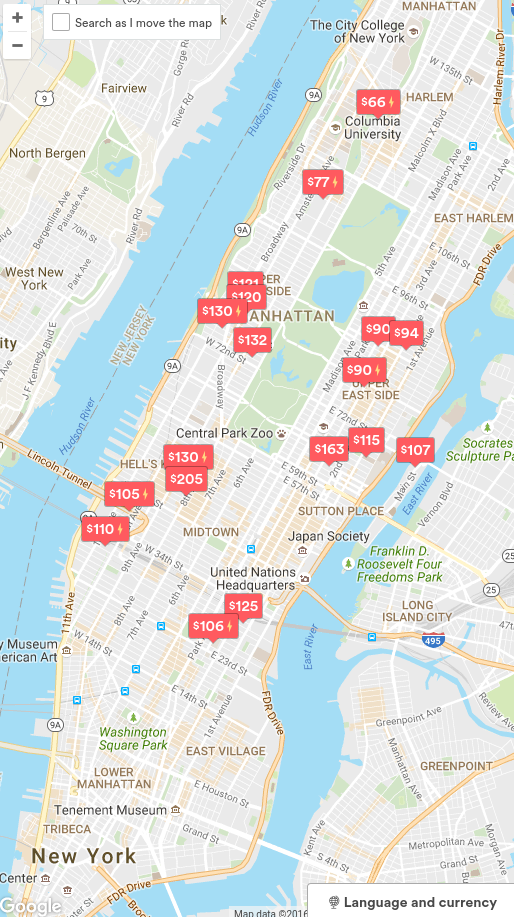

In [2]:
from IPython.display import Image
Image(filename='/home/mdesnoyer/Pictures/airbnb_nyc_search.png')

In [3]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os.path
import pandas as pd
from PIL import Image
import sklearn
import scipy.spatial
import scipy.stats

In [4]:
def prep_image_feature_data(data): 
    data.columns = [int(x.partition('.')[0]) for x in data.columns]
    data = data.T
    data.index.name = 'image_id'
    return data

In [5]:
def prep_metadata(json_dir):
    image_data = {}
    price_data = {}
    for fn in glob.iglob(os.path.join(json_dir, '*.json')):
        with open(fn) as f:
            data = json.load(f)
            listing_id = data['slideshow_props']['listing']['id']
            price_data[listing_id] = data['pricing']['pricing_quote']['p3_display_rate']['amount']
            for photo in data['slideshow_props']['photos']:
                image_data[photo['id']] = {'listing_id' : listing_id, 'rank': photo['sort_order']}
                
    image_data = pd.DataFrame(image_data).T
    price_data = pd.Series(price_data, name='price')
    return image_data.join(price_data, 'listing_id')

In [6]:
weights = pd.read_pickle('/home/mdesnoyer/src/neon3/model/demographics/20160713-aquilav2-weight.pkl')
bias = pd.read_pickle('/home/mdesnoyer/src/neon3/model/demographics/20160713-aquilav2-bias.pkl')
def compute_score_for_demo(X, gender='None', age='None'):
    '''Returns the score for gender `gender` and age `age` derived from
    feature vector X (a numpy array)
    '''
    b = bias[gender, age][0]
    W = weights[gender, age]
    try:
        scores = W.dot(X) + b
    except ValueError as e:
        raise ValueError(e)
    # return score
    # for now, we're nto going to return the score as multiindex 
    # series objects, but simply as floats.
    return scores

Load up the data, both the valence features and the metadata around each image

In [7]:
image_features = pd.read_pickle('/data/neon/airbnb/nyc_1bdrm_images.pkl')
image_features = prep_image_feature_data(image_features)
image_metadata = prep_metadata('/data/neon/airbnb/nyc_1bdrm')
image_metadata.index.name = 'image_id'

In [27]:
data = image_metadata.copy()
data['scores'] = compute_score_for_demo(image_features.T)
data = data.set_index(['listing_id', 'rank'], append=True).reorder_levels([1,2,0]).sort_index()
data = data.dropna()
# There is an outlier in this dataset where a listing was over $1000. Throw it out
data = data[data['price'] < 1000]
data

price    scores
listing_id rank image_id                  
49715      1    559324        95 -0.288280
           2    559330        95 -0.039772
           3    96866178      95 -0.683312
           4    559325        95 -0.650744
           5    559326        95 -0.230685
           6    559327        95 -1.010156
           7    559328        95 -1.191611
           8    559329        95 -1.230999
           9    559331        95 -0.402053
           10   559332        95 -0.470548
58059      1    635858        60 -0.518517
           2    635859        60 -0.427681
           3    635860        60 -0.419953
           4    635861        60 -0.436933
           5    635862        60 -0.575210
           6    635863        60 -0.585844
           7    635864        60 -0.564530
           8    635865        60 -0.196187
           9    635866        60 -0.429060
           10   635867        60 -0.380868
           11   635868        60 -0.352405
           12   635869        60 -0.505819
           13   635870        60 -1.250051
           14   635871        60 -0.634591
           15   635872        60 -0.890674
           16   635873        60 -0.742681
           17   635874        60 -0.627402
           18   635875        60 -0.758999
           19   635876        60 -0.237045
           20   635877        60 -0.489125
...                          ...       ...
15558614   4    222944656     95 -0.662440
           5    222944744     95 -0.360246
           6    222950408     95 -0.858082
           7    222950962     95 -0.456425
           8    222951283     95 -0.383949
15565886   1    223166772     70 -1.285274
           2    223166760     70 -1.063794
           3    223166791     70 -0.976069
           4    223166497     70 -0.516334
           5    223166484     70 -0.986389
           6    223166625     70 -0.726232
           7    223166663     70 -0.504590
           8    223166686     70 -0.516472
           9    223166733     70 -0.611879
           10   223166643     70 -0.855052
           11   223166707     70 -0.736796
           12   223166815     70 -0.516334
           13   223166826     70 -0.633714
           14   223166871     70 -0.442056
           15   223166849     70 -0.430603
           16   223168626     70 -0.972515
           17   223168609     70 -0.823203
           18   223168640     70 -0.865999
           19   223166589     70 -0.696445
           20   223166559     70 -0.418702
           21   223166540     70 -0.930625
           22   223166517     70 -1.069385
15589993   1    223714425     65 -0.243983
           2    223714407     65 -0.552947
           3    223714399     65 -0.484439

[4696 rows x 2 columns]

# Evaluate the Correlation 

In this section, we calculate the correlation of the price with the valence scores.

First up is the correlation for all images with the price of the listing the image is in. We see a statistically significant correlation.

In [28]:
print 'Spearman R: %f P-Value %f' % scipy.stats.spearmanr(data['scores'], data['price'])
print 'Pearson R: %f P-Value %f' % scipy.stats.pearsonr(data['scores'], data['price'])

Spearman R: 0.083948 P-Value 0.000000
Pearson R: 0.090005 P-Value 0.000000


Next, let us examine the correlation of the hero images that are used to represent the listings on search and as the main image.
Once again, we see a statistically significant correlation that is higher than just looking at all the images

In [29]:
# Correlation of the hero images with price
hero_images = data.loc[(slice(None), 1, slice(None)), :]
print 'Spearman R: %f P-Value %f' % scipy.stats.spearmanr(hero_images['scores'], hero_images['price'])
print 'Pearson R: %f P-Value %f' % scipy.stats.pearsonr(hero_images['scores'], hero_images['price'])

Spearman R: 0.171623 P-Value 0.003005
Pearson R: 0.187895 P-Value 0.001140


Finally, we can examine the mean valence score of all the images in the listing and compare it to the price. 
We see a correlation that is almost as high as the hero image.

In [30]:
# Correlation of the mean valence score of the images in each listing with price
mean_scores = data.groupby(level='listing_id').mean()
print 'Spearman R: %f P-Value %f' % scipy.stats.spearmanr(mean_scores['scores'], mean_scores['price'])
print 'Pearson R: %f P-Value %f' % scipy.stats.pearsonr(mean_scores['scores'], mean_scores['price'])

Spearman R: 0.155464 P-Value 0.007074
Pearson R: 0.157127 P-Value 0.006478
